<a href="https://colab.research.google.com/github/emyesme/CalcificationDetection/blob/Tacha/Pipeline12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries and Data Setup

## Import libraries

In [1]:
# just once to install opencv
!pip install opencv-python
!pip install matplotlib
!pip install numpy
#!pip install google-colab

#!pip install PyWavelets
#!pip install image_dehazer
!pip install -U scikit-image
#!pip install fastprogress
from fastprogress import master_bar, progress_bar

# import opencv
import cv2
# import numpy
import numpy as np
import math
from skimage import feature
import itertools
#import show special for google colab
from google.colab.patches import cv2_imshow
#import plt for display
import matplotlib.pyplot as plt

     |████████████████████████████████| 13.5 MB 5.0 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Drive Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive') # This will prompt for authorization.

Mounted at /content/drive


We put a shortcut in our drive to the image processing folder for this.

In [3]:
import os 
DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')

## Data Setup

In [4]:
#go into de directory of the images

# this have 3 outputs root directory, the folders in the path and the files in the path.
# we ignore _ the two first because we are not interested in those
_, _, images = next(os.walk(os.path.join(DATA_DIR,'images')))
_, _, breastMasks = next(os.walk(os.path.join(DATA_DIR,'masks')))
_, _, groundTruths = next(os.walk(os.path.join(DATA_DIR, 'groundtruths')))

images.sort()
breastMasks.sort()
groundTruths.sort()

# read numbers of normal images
normals = []
with open(os.path.join(DATA_DIR,'normals.txt')) as f:
    for line in f:
        normals.append(line[:-1])

## Google Colab Like a Pro

In [5]:
# https://medium.com/@robertbracco1/configuring-google-colab-like-a-pro-d61c253f7573#a642
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# Preprocessing

## DeHazing Using Dark Channel Prior and Guided Filter

Dehazing method proposed by the professor (also used in his paper)

Taken from here:
https://github.com/He-Zhang/image_dehaze
Info on readme.md of the repo

### Dark Channel

Here goes the theory behind this function 

In [6]:
# Here goes inputs --> output types
def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

### AtmLight

In [7]:
# Possibly change to grayscale would be nice
def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

### TransmissionEstimate

In [8]:
def TransmissionEstimate(im,A,sz):
    omega = 0.95;# the closer to 1 the stronger the darkenning
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

### GuidedFilter

In [9]:
def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

### TransmissionRefine

In [10]:
def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

### Recover

In [11]:
def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]
    return res

### deHazingDarkChannelPriorPy

In [12]:
def deHazingDarkChannelPriorPy(matrix, mask):

    I = matrix.astype(np.float64)/255
 
    dark = DarkChannel(I,15)
    A = AtmLight(I,dark)
    te = TransmissionEstimate(I,A,15)
    t = TransmissionRefine(matrix,te)
    J = Recover(I,t,A,0.1)
    preprocessed = J
    return preprocessed

# image = cv2.imread(DATA_DIR+"/images/53582422_3f0db31711fc9795_MG_R_ML_ANON.tif")
# dark, t, matrix, J = deHazingDarkChannelPriorPy(image, image)

## Grayscale Morphological Reconstruction

In [13]:
def morphReconstruction(matrix):
  matrix = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY)
  marker = cv2.morphologyEx(matrix, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (37,37)))
  marker_cur = marker
  mask = matrix
  
  while True:
    marker_prev = marker_cur.copy()

    marker_cur = cv2.dilate(marker_cur, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))
    marker_cur = cv2.min(marker_cur, mask)

    if cv2.countNonZero(marker_cur - marker_prev) == False:
        break
  
  return mask-marker_cur, marker_cur

## Image Dilation

In [14]:
def imgDilation(matrix):
  kernel = np.ones((3,3), np.uint8)
  img_dilation = cv2.dilate(matrix, kernel, iterations=3)
  return img_dilation

## CLAHE

In [15]:
def imgCLAHE(matrix):
  matrix = matrix.astype(np.uint16)
  #gray = cv2.cvtColor(matrix, cv2.COLOR_RGB2GRAY)
  
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl1 = clahe.apply(matrix)
  return cl1

## De-noising

In [16]:
def gaussianBlur(matrix):
  img_blurred = cv2.GaussianBlur(matrix, (5,5), 0)
  return img_blurred

## Other Tried Methods

**CLAHE (adaptive histogram equalization)**
  * CLAHE + dehazing = bad results, black image 
  * points less visible with CLAHE

**Linear stretching**
  * still missing linear streching
  * The code goes on forever (high computational cost)



# Candidate Extraction

##Hessian-Matrix-Based Analysis

Hessian-matrix-based analysis or difference of gaussians (DoH) blob detection from skimage:

https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=local%20binary%20pattern#skimage.feature.blob_doh

In [17]:
def candidateExtraction(matrix, mask):

  from skimage import feature
  
  # returns x,y,sigma of the blob
  blobs = feature.blob_doh(matrix,
                           min_sigma=1,
                           max_sigma=30,
                           num_sigma=10,
                           # The absolute lower bound for scale space maxima.
                           # Local maxima smaller than threshold are ignored.
                           # Reduce this to detect blobs with lower intensities.
                           # If threshold_rel is also specified, whichever threshold is larger will be used.
                           # If None, threshold_rel is used instead.
                           threshold=0.005,
                           # lower more sensible, more false positives bad also tinier calcifications detected
                           overlap=0.5,
                           log_scale=False,
                           threshold_rel=None
                           )
  # taken from the documentation
  # ...The downside is that this method can’t be used for detecting blobs of radius less than 3px
  # due to the box filters used in the approximation of Hessian Determinant.
  result = blobs
  return result

## Difference of Gaussians

Taken from:

https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=local%20binary%20pattern#skimage.feature.blob_dog

In [39]:
from math import sqrt
def candidateExtractionDoG(matrix, mask):
  from skimage import data, feature

  blobs = feature.blob_dog(matrix,
                           min_sigma=0.005,
                           max_sigma=50,
                           threshold=0.06)

  blobs[:, 2] = blobs[:, 2] * sqrt(2) # https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html

  result = blobs
  return result

# Feature Extraction

In [19]:
# Get Ground Truth for each patch
def patchGroundTruth(candidate, groundTruth):

  left = int((candidate[0] - candidate[2]) if ((candidate[0] - candidate[2]) > 0) else 0)
  right = int((candidate[0] + candidate[2]) if ((candidate[0] + candidate[2]) < groundTruth.shape[0]) else groundTruth.shape[0])
  top = int((candidate[1] - candidate[2]) if ((candidate[1] - candidate[2]) > 0) else 0)
  bottom = int((candidate[1] + candidate[2]) if ((candidate[1] + candidate[2]) < groundTruth.shape[1]) else groundTruth.shape[1])

  truePatch = groundTruth[left : right,
                          top  : bottom]
  sum = np.sum(truePatch)
  if sum > 0:
    return str(1)
  else:
    return str(0)

Video tutorial on how to use GLCM:

* https://www.youtube.com/watch?v=5x-CIHRmMNY

Documentation and example on GLCM:

* https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

Paper:

*  https://ijcrr.com/uploads/3454_pdf.pdf

GLCM Properties documentation:

* https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycoprops

GLCM Gray co-matrix documentation:

* https://stackoverflow.com/questions/54512617/creating-gray-level-co-occurrence-matrix-from-16-bit-image
(why can't we have 16 bit type for the coocurrence matrix computation)

* https://www.sciencedirect.com/topics/engineering/cooccurrence-matrix (simple explanation GLCM)

Output of the GLCM command: 

the gray-level co-occurrence histogram. The value P[i,j,d,theta]
is the number of times that gray-level j occurs at a distance d
and at an angle theta from gray-level i.
If normed is False, the output is of type uint32, otherwise it is float64.
The dimensions are: levels x levels x number of distances x number of angles.

In [33]:
# Using GLCM with the given candidates
def featuresExtraction(matrix, candidates, features, mask, groundTruth, image, folder):
  
  # No candidates, no extraction needed
  if (len(candidates) == 0):
    return []
  # angles
  angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

  flag = True
  for index, candidate in enumerate(progress_bar(candidates)):

    distances = [1] # probably we need bigger

    # combination of distances and angles as couples of values
    distancesAngles = list(itertools.product(distances, angles))

    # to use them as coordinates they have to be integers
    candidate = candidate.astype(np.int64)

    if candidate[2] == 0:
      candidate[2] = 1

    # candidates are y,x and sigma
    left = int((candidate[0] - candidate[2]) if ((candidate[0] - candidate[2]) > 0) else 0)
    right = int((candidate[0] + candidate[2]) if ((candidate[0] + candidate[2]) < matrix.shape[0]) else matrix.shape[0])
    top = int((candidate[1] - candidate[2]) if ((candidate[1] - candidate[2]) > 0) else 0)
    bottom = int((candidate[1] + candidate[2]) if ((candidate[1] + candidate[2]) < matrix.shape[1]) else matrix.shape[1])

    patchCandidate = matrix[left: right,
                            top : bottom]

    print(candidate)

    # graycomatrix, glcm, receive unsigned integer type
    patchCandidate = patchCandidate.astype(np.uint8)

    dictFeatures = {}
    dictFeatures = {'name': 'patch_' + str(index) + '_' + str(image.split(".")[0]),
                    'label': patchGroundTruth(candidate, groundTruth),
                    'x': candidate[1],
                    'y': candidate[0],
                    'sigma': candidate[2]}

    for distanceAngle in distancesAngles:
      distance = distanceAngle[0]
      angle = distanceAngle[1]
      
      # get the degree to use it as name for the column
      name = str(angle*(180.0/np.pi))

      # input image, distance in pixels, angles
      glcm = feature.graycomatrix(patchCandidate, [ distance ], [ angle ])

      # properties
      dictFeatures['contrast'+ str(distance) + name] = feature.graycoprops(glcm, 'contrast')[0][0]
      dictFeatures['dissimilarity' + str(distance) + name] = feature.graycoprops(glcm, 'dissimilarity')[0][0]
      dictFeatures['homogeneity' + str(distance) + name] = feature.graycoprops(glcm, 'homogeneity')[0][0]
      dictFeatures['energy' + str(distance) + name] = feature.graycoprops(glcm, 'energy')[0][0]
      dictFeatures['correlation' + str(distance) + name] = feature.graycoprops(glcm, 'correlation')[0][0]
      dictFeatures['ASM' + str(distance) + name] = feature.graycoprops(glcm, 'ASM')[0][0]

    # add to the dataframe the features for this patch
    features = features.append(dictFeatures, ignore_index=True)

  # save in the csv
  flag = writeFeatures(features, flag, folder, image, "features")

  return features

In [21]:
def writeFeatures(features, flag, folder, image, name):
  if(flag):
    features.to_csv(os.path.join('/content',
                                 'drive',
                                 'MyDrive',
                                 'Results',
                                 folder,
                                 str(image.split('.')[0]) + '_'+ name + '.csv'),
                    mode='a',
                    index=False)
    flag = False
  else:
    features.to_csv(os.path.join('/content',
                                 'drive',
                                 'MyDrive',
                                 'Results',
                                 folder,
                                 str(image.split('.')[0]) + '_'+ name + '.csv'),
                  mode='a',
                  header=False,
                  index=False)
  return flag

# Connected Components

In [22]:
# function to get connected components of the ground truth binary image
def componentsStatsGroundTruth(matrix):
    # getting the info of the components in the ground truth
    # second value is connectivity 4 or 8
    connectedComponentsGroundTruth = cv2.connectedComponentsWithStats(matrix, 8, cv2.CV_32S)

    # Get the results
    # The first cell is the number of labels
    num_labels = connectedComponentsGroundTruth[0]
    # The second cell is the label matrix
    labels = connectedComponentsGroundTruth[1]
    # The third cell is the stat matrix
    stats = connectedComponentsGroundTruth[2]
    # The fourth cell is the centroid matrix
    centroids = connectedComponentsGroundTruth[3]

    return num_labels, labels, stats, centroids

# Show Images

In [23]:
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

# function to draw the grid to display
def display_grid(figure, axis, img, imgGroundTruth, preprocessed, candidates, features):
  # draw in the axis the img
  axis[0][0].imshow(img)
  # switch off the axis of the plot
  axis[0][0].axis('off')
  # set a title for the plot
  axis[0][0].set_title('Image')

  axis[0][1].imshow(imgGroundTruth, cmap='gray')
  axis[0][1].axis('off')
  axis[0][1].set_title('Ground Truth')

  axis[0][2].imshow(imgMask)
  axis[0][2].axis('off')
  axis[0][2].set_title('Breast Mask')

  axis[1][0].imshow(preprocessed, cmap='gray')
  axis[1][0].axis('off')
  axis[1][0].set_title('Preprocessed')

  # draw candidates as circles
  axis[1][1].imshow(preprocessed, cmap='gray')
  axis[1][1].axis('off')
  axis[1][1].set_title('Candidates')

  # Now, loop through coord arrays, and create a circle at each x,y pair
  for y,x,sigma in candidates:

    blob = Circle((x,y), sigma*5, color='blue', fill=False)
    axis[1][1].add_patch(blob)

    rect=mpatches.Rectangle((x,y),sigma,sigma, 
                        fill=False,
                        color="red",
                       linewidth=2)
    axis[1][1].add_patch(rect)

  axis[1][2].imshow(imgGroundTruth, cmap='gray')
  axis[1][2].axis('off')
  axis[1][2].set_title('compare with ground truth and candidates')

  # Now, loop through coord arrays, and create a circle at each x,y pair
  for y,x,sigma in candidates:
    blob = Circle((x,y), sigma, color='blue', fill=False)
    axis[1][2].add_patch(blob)
  
  return figure, axis

# Main

[ 148 3327   13]
[ 164 3327    8]
[ 206 3327    8]
[1869 1936    8]
[1885 2028   20]
[2702 2581   13]
[1857 2073    8]
[  53 3327    8]
[1888 2002    5]
[2436 2021   13]
[1900 2054    8]
[2704 2623   13]
[1888 1988    3]
[ 123 3320    1]
[2752 2628    5]
[1911 2027    3]
[1869 1921    5]
[ 170 3321    1]
[1860 2102    8]
[   8 3325    5]
[2714 2611    3]
[2418 2001    8]
[ 234 3327    8]
[  93 3327    5]
[ 114 3308    3]
[1858 2005    5]
[ 354 3327    8]
[1851 2064    1]
[  74 3327    8]
[ 272 3327    8]
[2401 2059   13]
[  88 3208    3]
[1883 1969    8]
[1883 1997    1]
[ 155 3315    1]
[ 117 3311    1]
[2705 2723    5]
[ 106 3322    1]
[ 129 3320    1]
[ 220 3322    1]
[ 110 3321    1]
[2727 2526   13]
[ 111 3311    1]
[ 385 3327    5]
[   3 3321    1]
[  98 3321    1]
[1889 1997    1]
[ 120 3320    1]
[ 100 3278    8]
[2631 3037   13]
[2663 2566    8]
[1857 2118    5]
[2651 2985    8]
[ 190 3321    1]
[   3 3327    1]
[1914 2024    1]
[2716 2614    1]
[1863 1930    1]
[1872 1951    

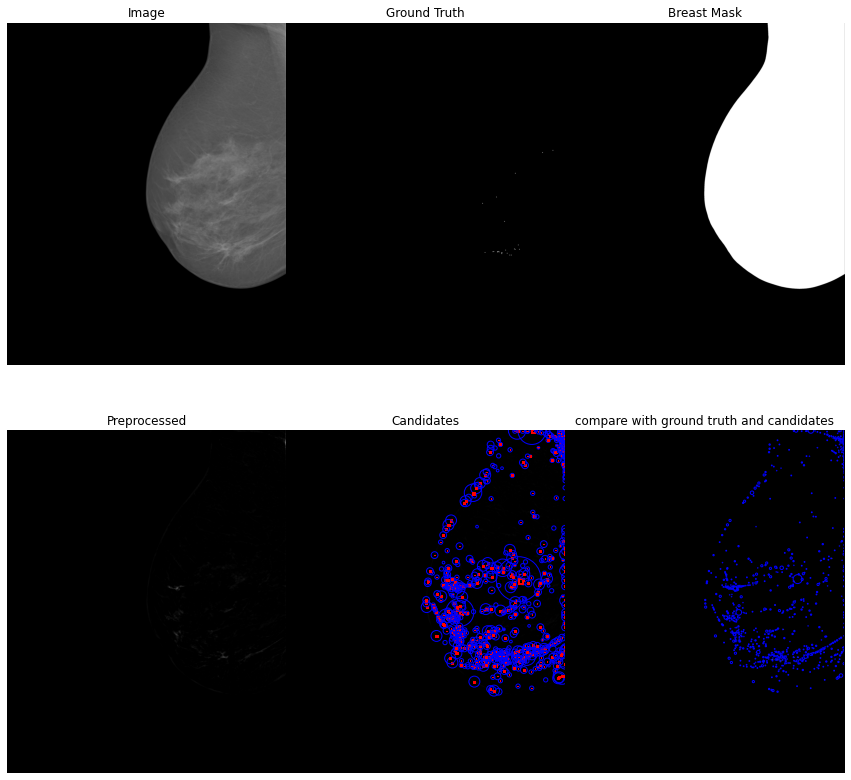

1602


In [40]:
import copy
import pandas as pd

#go through the image files 
for image, breastMask, groundTruth in zip(progress_bar(images), breastMasks, groundTruths):

  # to save the features generated with the glcm
  features = pd.DataFrame(dtype=np.float64)

  # 20588020, 7717, 5328, 3787, 5725, 3859, 6934, 50995872
  digits = '24055600'

  if ((digits in image) and (digits in breastMask) and ('mask' in breastMask)):
  #if ('mask' in breastMask):
  #if image not in already:
    #upload images
    img = cv2.imread(os.path.join(DATA_DIR,'images',image))
    imgMask = cv2.imread(os.path.join(DATA_DIR, 'masks', breastMask))
    imgGroundTruth = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', image), cv2.IMREAD_GRAYSCALE)
    imgCopy = copy.deepcopy(img)

    imgCopy = cv2.cvtColor(imgCopy, cv2.COLOR_RGB2GRAY)
    preprocessed = imgCLAHE(imgCopy)
    preprocessed = cv2.cvtColor(preprocessed, cv2.COLOR_GRAY2RGB)
    preprocessed = deHazingDarkChannelPriorPy(preprocessed, imgMask)
    preprocessed = preprocessed.astype(np.float32)
    preprocessedMorphMc, preprocessedMorphBg = morphReconstruction(preprocessed)   
    
    preprocessedBlurDil = imgDilation(preprocessedMorphMc)


    # candidate extraction #
    copyPreprocessed = copy.deepcopy(preprocessedMorphMc)
    copyPreprocessedBlurDil = copy.deepcopy(preprocessedBlurDil)

         # we have to change np.float64 to np.float32 for the grayscale conversion
    copyPreprocessedBlurDil = copyPreprocessedBlurDil.astype(np.float32)
    #copyPreprocessedBlurDil = cv2.cvtColor(copyPreprocessedBlurDil, cv2.COLOR_BGR2GRAY)

    candidates = candidateExtractionDoG(copyPreprocessedBlurDil, imgMask)

    # feature extraction #

    copyPreprocessed = copyPreprocessed.astype(np.float32)
    # copyPreprocessed = cv2.cvtColor(copyPreprocessed, cv2.COLOR_GRAY2BGR)
    # copyPreprocessed = cv2.cvtColor(copyPreprocessed, cv2.COLOR_BGR2GRAY)
    features = featuresExtraction(copyPreprocessed, candidates, features, imgMask, imgGroundTruth, image, "test")
    
    # ML must be applied for the classification of the features extracted

    ################ ERASE MEMORY
    # import gc
    # del features
    # del preprocessed
    # del candidates
    # # del blobs
    # del copyPreprocessed
    # del imgCopy
    # del img
    # del imgMask
    # del imgGroundTruth
    # gc.collect()
    ############################

    # end image processing part #

    # display related #

    # matrix of plots and size of the figure
    figure, axis = plt.subplots(2, 3, figsize=(15,15))
    display_grid(figure, axis, img, imgGroundTruth, preprocessedMorphMc, candidates, features)
    plt.subplots_adjust(wspace=0, hspace=0)

    # display figure with image
    plt.show() 
    print(len(candidates))

## CONCLUSIONS FOR PREPROCESSING

* still missing quantum noise supression

* details in the phd defense file

* Observations from the results:
    * fiber intersections may also appear as bright spots (false positives)

* THINGS WE NOTICE BETWEEN BOTH DEHAZING METHODS
    * Better suppression of fatty tissue (noise) and greater enhancement of brightness of desired feature (microcalcifications)
    * sometimes for the other dehazing method black patches become present in the fatty tissue
    * this did not happen in the dehazing with dark channel prior (and guided filter)
    * sharper
    * enhances the contrast and details

* Observations from the results:
    * images with pectoral muscule cause false positives